In [1]:
import matplotlib.pyplot as plt
from PIL import Image
from PIL.Image import NEAREST
import numpy as np
import cv2
import os
import imutils
from random import random, seed, randint

from scipy import ndimage as ndi
from scipy.spatial.distance import euclidean
from skimage.morphology import watershed, disk
from skimage.feature import peak_local_max
from torchvision.transforms.functional import pad, resized_crop, resize, center_crop, rotate, hflip, to_pil_image
# from torch.random import torch.random.manual_seed(seed)

from processing import *

IMAGES_LIMIT = 5000

In [2]:
# o=get_origs()
# get_clahes(o)
# cell_masks = get_cell_masks()
# cell_markers = get_cell_markers(cell_masks, 24)
# weight_maps = get_weight_maps(cell_markers, False)

# pimg(weight_maps[1])

def plot_two_images(imgL, imgR, titleL, titleR):
    f = plt.figure()
    f.add_subplot(1,2, 1)
    plt.imshow(imgL, cmap='gray')
    plt.title(titleL)
    f.add_subplot(1,2, 2)
    plt.imshow(imgR, cmap='gray')
    plt.title(titleR)
    plt.show(block=True)

In [3]:
def get_pred_masks():
    return get_binary_cell_masks(get_cell_masks())

def get_pred_markers(pred_masks, e_r):
    return get_binary_cell_markers(get_cell_masks(), e_r)

In [4]:
def threshold_binary_image(img, thresh=0.5):
    image = img.copy()
    return (image*1.0 >= thresh).astype('uint8')

E:\VMShared\vision_group_c\processing.py:117: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(origs)
<ipython-input-5-5b6f3cd5b766>:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print(out.shape, h, w, str(np.alltrue(inp == out)))


(700, 1100)
(704, 1104) 4 4 False
(700, 1100) True


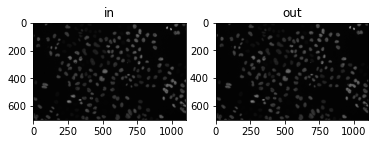

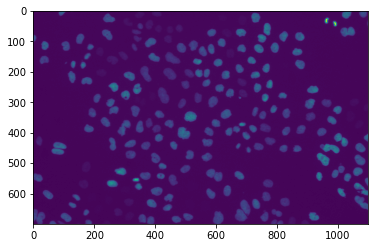

In [5]:
inp = get_origs()[0]
print(inp.shape)
out, (h, w) = get_padded16(inp)
print(out.shape, h, w, str(np.alltrue(inp == out)))
un_pad = get_unpadded(out, h, w)
print(un_pad.shape, str(np.alltrue(inp == un_pad)))
plot_two_images(inp, out, "in", "out")
pimg(un_pad)

In [6]:
# def img_aug(dataset, new_prefix = "_aug"):
#     #constants
#     num_aug_multiplier = 10
    
#     new_dir_name = dataset + new_prefix
    
#     try:
#         os.mkdir(new_dir_name)
#         os.mkdir(os.path.join(new_dir_name, "originals"))
#         os.mkdir(os.path.join(new_dir_name, "masks"))
#     except:
#         print("One of the directories to be created already exists. Clear and try again.")
#         return
    
#     data = []
#     paths = [dataset + '/01', dataset + '/02']
#     count = 0
    
#     for path in paths:
#         mask_path = path + '_ST'
#         mask_path = os.path.join(mask_path, "SEG")
        
#         for f in os.listdir(mask_path):
#             if count >= IMAGES_LIMIT:
#                 break

#             if not f.endswith(".tif"):
#                 continue
#             image_np = cv2.imread(os.path.join(path, f.replace('man_seg', 't')), cv2.IMREAD_GRAYSCALE)
#             mask_np = cv2.imread(os.path.join(mask_path, f), cv2.IMREAD_UNCHANGED)
            
# #             image_pil = Image.open( os.path.join(path, f.replace('man_seg', 't')) )
# #             mask_pil = Image.open( os.path.join(mask_path, f) )
#             image_pil = to_pil_image(image_np)
#             mask_pil = Image.open( os.path.join(mask_path, f) )
#             mask_pil = mask_pil.convert("L")

#             print("   Loaded " + os.path.join(mask_path, f) + ", " + os.path.join(path, f.replace('man_seg', 't')))
            
#             index = 't' + str(count) + ".tif"
#             count += 1
            
#             cv2.imwrite(os.path.join(new_dir_name, "originals", index ), image_np)
#             cv2.imwrite(os.path.join(new_dir_name, "masks", index ), mask_np)
            
#             for i in range(num_aug_multiplier):
#                 new_img = None
#                 new_mask = None
#                 image = image_pil
#                 mask = mask_pil
                
#                 seed()
#                 seed_ = randint(0,1000)
                
#                 index = 't' + str(count) + ".tif"
#                 count += 1
                
#                 seed(seed_)
#                 if random() > 0.5:
#                     pad_size = int(randint(0,int(image.height*0.2)))
#                     pad_size = (pad_size)
#                     new_img = pad(image, pad_size, padding_mode='reflect')
#                     new_img = resize(new_img, (image.height, image.width))
#                 else:
#                     t_size = image.height * (0.6 + ( random() * 0.39 ) )
#                     new_img = center_crop(image, (t_size, t_size))
#                     new_img = resize(new_img, (image.height, image.width) )
                
#                 pad_size = int(image.height*0.5)
#                 pad_size = (pad_size)
#                 new_img = pad(new_img, pad_size, padding_mode='reflect')
#                 new_img = rotate(new_img, randint(0,360), expand=False, fill=0)
# #                 new_img = resize(new_img, (image.height, image.width) )
#                 new_img = center_crop(new_img, (image.height, image.width) )
                
#                 new_img = hflip(new_img)
#                 new_img.save( os.path.join(new_dir_name, "originals", index) )
                
#                 seed(seed_)
#                 if random() > 0.5:
#                     pad_size = int(randint(0, int(mask.height*0.2)))
#                     pad_size = (pad_size)
#                     new_mask = pad(mask, pad_size, padding_mode='reflect')
#                     new_mask = resize(new_mask, (mask.height, mask.width), interpolation=NEAREST)
#                 else:
#                     t_size = mask.height * (0.6 + ( random() * 0.39 ) )
#                     new_mask = center_crop(mask, (t_size, t_size) )
#                     new_mask = resize(new_mask, (mask.height, mask.width), interpolation=NEAREST)
                
#                 pad_size = int(mask.height*0.5)
#                 pad_size = (pad_size)
#                 new_mask = pad(new_mask, pad_size, padding_mode='reflect')
#                 new_mask = rotate(new_mask, randint(0,360), expand=False, fill=0)
# #                 new_mask = resize(new_mask, (mask.height, mask.width), interpolation=NEAREST )
#                 new_mask = center_crop(new_mask, (mask.height, mask.width) )
                
#                 new_mask = hflip(new_mask)
#                 new_mask.save( os.path.join(new_dir_name, "masks", index ) )
                
# #                 plot_two_images(mask, new_mask, "Gen Img", "Gen Mask")
# #                 plot_two_images(new_img, get_markers(np.asarray(new_mask), 2), "img", "markers")
# #                 print(len(np.unique(np.asarray(mask))) - len(np.unique(np.asarray(new_mask))), np.unique(np.asarray(mask)), np.unique(np.asarray(new_mask)))
                
# #                 assert(len(np.unique(np.asarray(mask))) - len(np.unique(np.asarray(new_mask))) == 0)
    
#                 print(index)
#     print("Finished.")
                
# img_aug("Fluo-2")

In [37]:
def create_preprocessed_cache(dataset, new_dir_name=None):
    #constants
    EROS_RADIUS=3
    CL = 3.0
    TGS = (8, 8)

    if new_dir_name == None:
        new_dir_name = dataset+"_cache"
    
    try:
        os.mkdir(new_dir_name)
        os.mkdir(os.path.join(new_dir_name, "originals"))
        os.mkdir(os.path.join(new_dir_name, "clahes"))
        os.mkdir(os.path.join(new_dir_name, "masks"))
        os.mkdir(os.path.join(new_dir_name, "markers"))
        os.mkdir(os.path.join(new_dir_name, "weight_maps"))
    except:
        print("One of the directories to be created already exists. Clear and try again.")
        return
    
    data = []
    paths = [dataset + '/01', dataset + '/02']
    count = 0
    
    for path in paths:
        mask_path = path + '_ST'
        mask_path = os.path.join(mask_path, "SEG")
        
        for f in os.listdir(mask_path):
            if count >= IMAGES_LIMIT:
                break
            
            if not f.endswith(".tif"):
                continue
            image = cv2.imread(os.path.join(path, f.replace('man_seg', 't')), cv2.IMREAD_GRAYSCALE)
            clahe = equalize_clahe(image, CL, TGS).astype(np.float32)
            mask = cv2.imread(os.path.join(mask_path, f), cv2.IMREAD_UNCHANGED)
            print("   Loaded " + os.path.join(mask_path, f) + ", " + os.path.join(path, f.replace('man_seg', 't')))
            
            # WARNING: FOLLOWING SECTION ONLY FOR FLUO, DISABLE FOR OTHERS. 
            # ASSUMES MASK SHAPE IS SAME AS IMAGE SHAPE
            cont_stretched_image = cont_stretch(image).astype('uint8')
            clahe = equalize_clahe( cont_stretched_image , CL, TGS).astype(np.float32)

            image, _ = get_padded16(image)
            clahe, padding_dimpair = get_padded16(clahe)
            mask, _ = get_padded16(mask)
            print("padding dimensions(top, left): ", padding_dimpair)
            
            # END WARNING SECTION
            
            # Generate the Cell Mask and Markers from the Mask
            cell_mask = (mask > 0).astype(np.uint8)
            markers = (get_markers(mask, EROS_RADIUS) > 0).astype(np.uint8)
            weight_map = get_weight_map(markers)
            
            index = 't' + str(count) + ".npy"
            count += 1 
            
            np.save(os.path.join(new_dir_name, "originals", index ), image)
            np.save(os.path.join(new_dir_name, "clahes", index ), clahe)
            np.save(os.path.join(new_dir_name, "masks", index ), cell_mask)
            np.save(os.path.join(new_dir_name, "markers", index ), markers)
            np.save(os.path.join(new_dir_name, "weight_maps", index ), weight_map)
            
#             cv2.imwrite(os.path.join(new_dir_name, "originals", index ), image)
#             cv2.imwrite(os.path.join(new_dir_name, "clahes", index ), clahe)
#             cv2.imwrite(os.path.join(new_dir_name, "masks", index ), cell_mask)
#             cv2.imwrite(os.path.join(new_dir_name, "markers", index ), markers)
#             cv2.imwrite(os.path.join(new_dir_name, "weight_maps", index ), weight_map)
    
            print(count)
#             plot_two_images(clahe, cell_mask, "orig", "mask")
#             plot_two_images(markers, weight_map, "marker", "weight map")

create_preprocessed_cache('Fluo-3', new_dir_name="Fluo-4_cache")

   Loaded Fluo-3/01_ST\SEG\t0.tif, Fluo-3/01\t0.tif
padding dimensions(top, left):  (4, 4)
1
   Loaded Fluo-3/01_ST\SEG\t1.tif, Fluo-3/01\t1.tif
padding dimensions(top, left):  (4, 4)
2
   Loaded Fluo-3/01_ST\SEG\t10.tif, Fluo-3/01\t10.tif
padding dimensions(top, left):  (4, 4)
3
   Loaded Fluo-3/01_ST\SEG\t100.tif, Fluo-3/01\t100.tif
padding dimensions(top, left):  (4, 4)
4
   Loaded Fluo-3/01_ST\SEG\t1000.tif, Fluo-3/01\t1000.tif
padding dimensions(top, left):  (4, 4)
5
   Loaded Fluo-3/01_ST\SEG\t1001.tif, Fluo-3/01\t1001.tif
padding dimensions(top, left):  (4, 4)
6
   Loaded Fluo-3/01_ST\SEG\t1002.tif, Fluo-3/01\t1002.tif
padding dimensions(top, left):  (4, 4)
7
   Loaded Fluo-3/01_ST\SEG\t1003.tif, Fluo-3/01\t1003.tif
padding dimensions(top, left):  (4, 4)
8
   Loaded Fluo-3/01_ST\SEG\t1004.tif, Fluo-3/01\t1004.tif
padding dimensions(top, left):  (4, 4)
9
   Loaded Fluo-3/01_ST\SEG\t1005.tif, Fluo-3/01\t1005.tif
padding dimensions(top, left):  (4, 4)
10
   Loaded Fluo-3/01_ST\SEG\

83
   Loaded Fluo-3/01_ST\SEG\t1072.tif, Fluo-3/01\t1072.tif
padding dimensions(top, left):  (4, 4)
84
   Loaded Fluo-3/01_ST\SEG\t1073.tif, Fluo-3/01\t1073.tif
padding dimensions(top, left):  (4, 4)
85
   Loaded Fluo-3/01_ST\SEG\t1074.tif, Fluo-3/01\t1074.tif
padding dimensions(top, left):  (4, 4)
86
   Loaded Fluo-3/01_ST\SEG\t1075.tif, Fluo-3/01\t1075.tif
padding dimensions(top, left):  (4, 4)
87
   Loaded Fluo-3/01_ST\SEG\t1076.tif, Fluo-3/01\t1076.tif
padding dimensions(top, left):  (4, 4)
88
   Loaded Fluo-3/01_ST\SEG\t1077.tif, Fluo-3/01\t1077.tif
padding dimensions(top, left):  (4, 4)
89
   Loaded Fluo-3/01_ST\SEG\t1078.tif, Fluo-3/01\t1078.tif
padding dimensions(top, left):  (4, 4)
90
   Loaded Fluo-3/01_ST\SEG\t1079.tif, Fluo-3/01\t1079.tif
padding dimensions(top, left):  (4, 4)
91
   Loaded Fluo-3/01_ST\SEG\t108.tif, Fluo-3/01\t108.tif
padding dimensions(top, left):  (4, 4)
92
   Loaded Fluo-3/01_ST\SEG\t1080.tif, Fluo-3/01\t1080.tif
padding dimensions(top, left):  (4, 4)
93

165
   Loaded Fluo-3/01_ST\SEG\t1146.tif, Fluo-3/01\t1146.tif
padding dimensions(top, left):  (4, 4)
166
   Loaded Fluo-3/01_ST\SEG\t1147.tif, Fluo-3/01\t1147.tif
padding dimensions(top, left):  (4, 4)
167
   Loaded Fluo-3/01_ST\SEG\t1148.tif, Fluo-3/01\t1148.tif
padding dimensions(top, left):  (4, 4)
168
   Loaded Fluo-3/01_ST\SEG\t1149.tif, Fluo-3/01\t1149.tif
padding dimensions(top, left):  (4, 4)
169
   Loaded Fluo-3/01_ST\SEG\t115.tif, Fluo-3/01\t115.tif
padding dimensions(top, left):  (4, 4)
170
   Loaded Fluo-3/01_ST\SEG\t1150.tif, Fluo-3/01\t1150.tif
padding dimensions(top, left):  (4, 4)
171
   Loaded Fluo-3/01_ST\SEG\t1151.tif, Fluo-3/01\t1151.tif
padding dimensions(top, left):  (4, 4)
172
   Loaded Fluo-3/01_ST\SEG\t1152.tif, Fluo-3/01\t1152.tif
padding dimensions(top, left):  (4, 4)
173
   Loaded Fluo-3/01_ST\SEG\t1153.tif, Fluo-3/01\t1153.tif
padding dimensions(top, left):  (4, 4)
174
   Loaded Fluo-3/01_ST\SEG\t1154.tif, Fluo-3/01\t1154.tif
padding dimensions(top, left): 

247
   Loaded Fluo-3/01_ST\SEG\t122.tif, Fluo-3/01\t122.tif
padding dimensions(top, left):  (4, 4)
248
   Loaded Fluo-3/01_ST\SEG\t1220.tif, Fluo-3/01\t1220.tif
padding dimensions(top, left):  (4, 4)
249
   Loaded Fluo-3/01_ST\SEG\t1221.tif, Fluo-3/01\t1221.tif
padding dimensions(top, left):  (4, 4)
250
   Loaded Fluo-3/01_ST\SEG\t1222.tif, Fluo-3/01\t1222.tif
padding dimensions(top, left):  (4, 4)
251
   Loaded Fluo-3/01_ST\SEG\t1223.tif, Fluo-3/01\t1223.tif
padding dimensions(top, left):  (4, 4)
252
   Loaded Fluo-3/01_ST\SEG\t1224.tif, Fluo-3/01\t1224.tif
padding dimensions(top, left):  (4, 4)
253
   Loaded Fluo-3/01_ST\SEG\t1225.tif, Fluo-3/01\t1225.tif
padding dimensions(top, left):  (4, 4)
254
   Loaded Fluo-3/01_ST\SEG\t1226.tif, Fluo-3/01\t1226.tif
padding dimensions(top, left):  (4, 4)
255
   Loaded Fluo-3/01_ST\SEG\t1227.tif, Fluo-3/01\t1227.tif
padding dimensions(top, left):  (4, 4)
256
   Loaded Fluo-3/01_ST\SEG\t1228.tif, Fluo-3/01\t1228.tif
padding dimensions(top, left): 

329
   Loaded Fluo-3/01_ST\SEG\t1294.tif, Fluo-3/01\t1294.tif
padding dimensions(top, left):  (4, 4)
330
   Loaded Fluo-3/01_ST\SEG\t1295.tif, Fluo-3/01\t1295.tif
padding dimensions(top, left):  (4, 4)
331
   Loaded Fluo-3/01_ST\SEG\t1296.tif, Fluo-3/01\t1296.tif
padding dimensions(top, left):  (4, 4)
332
   Loaded Fluo-3/01_ST\SEG\t1297.tif, Fluo-3/01\t1297.tif
padding dimensions(top, left):  (4, 4)
333
   Loaded Fluo-3/01_ST\SEG\t1298.tif, Fluo-3/01\t1298.tif
padding dimensions(top, left):  (4, 4)
334
   Loaded Fluo-3/01_ST\SEG\t1299.tif, Fluo-3/01\t1299.tif
padding dimensions(top, left):  (4, 4)
335
   Loaded Fluo-3/01_ST\SEG\t13.tif, Fluo-3/01\t13.tif
padding dimensions(top, left):  (4, 4)
336
   Loaded Fluo-3/01_ST\SEG\t130.tif, Fluo-3/01\t130.tif
padding dimensions(top, left):  (4, 4)
337
   Loaded Fluo-3/01_ST\SEG\t1300.tif, Fluo-3/01\t1300.tif
padding dimensions(top, left):  (4, 4)
338
   Loaded Fluo-3/01_ST\SEG\t1301.tif, Fluo-3/01\t1301.tif
padding dimensions(top, left):  (4,

411
   Loaded Fluo-3/01_ST\SEG\t1368.tif, Fluo-3/01\t1368.tif
padding dimensions(top, left):  (4, 4)
412
   Loaded Fluo-3/01_ST\SEG\t1369.tif, Fluo-3/01\t1369.tif
padding dimensions(top, left):  (4, 4)
413
   Loaded Fluo-3/01_ST\SEG\t137.tif, Fluo-3/01\t137.tif
padding dimensions(top, left):  (4, 4)
414
   Loaded Fluo-3/01_ST\SEG\t1370.tif, Fluo-3/01\t1370.tif
padding dimensions(top, left):  (4, 4)
415
   Loaded Fluo-3/01_ST\SEG\t1371.tif, Fluo-3/01\t1371.tif
padding dimensions(top, left):  (4, 4)
416
   Loaded Fluo-3/01_ST\SEG\t1372.tif, Fluo-3/01\t1372.tif
padding dimensions(top, left):  (4, 4)
417
   Loaded Fluo-3/01_ST\SEG\t1373.tif, Fluo-3/01\t1373.tif
padding dimensions(top, left):  (4, 4)
418
   Loaded Fluo-3/01_ST\SEG\t1374.tif, Fluo-3/01\t1374.tif
padding dimensions(top, left):  (4, 4)
419
   Loaded Fluo-3/01_ST\SEG\t1375.tif, Fluo-3/01\t1375.tif
padding dimensions(top, left):  (4, 4)
420
   Loaded Fluo-3/01_ST\SEG\t1376.tif, Fluo-3/01\t1376.tif
padding dimensions(top, left): 

493
   Loaded Fluo-3/01_ST\SEG\t1441.tif, Fluo-3/01\t1441.tif
padding dimensions(top, left):  (4, 4)
494
   Loaded Fluo-3/01_ST\SEG\t1442.tif, Fluo-3/01\t1442.tif
padding dimensions(top, left):  (4, 4)
495
   Loaded Fluo-3/01_ST\SEG\t1443.tif, Fluo-3/01\t1443.tif
padding dimensions(top, left):  (4, 4)
496
   Loaded Fluo-3/01_ST\SEG\t1444.tif, Fluo-3/01\t1444.tif
padding dimensions(top, left):  (4, 4)
497
   Loaded Fluo-3/01_ST\SEG\t1445.tif, Fluo-3/01\t1445.tif
padding dimensions(top, left):  (4, 4)
498
   Loaded Fluo-3/01_ST\SEG\t1446.tif, Fluo-3/01\t1446.tif
padding dimensions(top, left):  (4, 4)
499
   Loaded Fluo-3/01_ST\SEG\t1447.tif, Fluo-3/01\t1447.tif
padding dimensions(top, left):  (4, 4)
500
   Loaded Fluo-3/01_ST\SEG\t1448.tif, Fluo-3/01\t1448.tif
padding dimensions(top, left):  (4, 4)
501
   Loaded Fluo-3/01_ST\SEG\t1449.tif, Fluo-3/01\t1449.tif
padding dimensions(top, left):  (4, 4)
502
   Loaded Fluo-3/01_ST\SEG\t145.tif, Fluo-3/01\t145.tif
padding dimensions(top, left): 

575
   Loaded Fluo-3/01_ST\SEG\t1515.tif, Fluo-3/01\t1515.tif
padding dimensions(top, left):  (4, 4)
576
   Loaded Fluo-3/01_ST\SEG\t1516.tif, Fluo-3/01\t1516.tif
padding dimensions(top, left):  (4, 4)
577
   Loaded Fluo-3/01_ST\SEG\t1517.tif, Fluo-3/01\t1517.tif
padding dimensions(top, left):  (4, 4)
578
   Loaded Fluo-3/01_ST\SEG\t1518.tif, Fluo-3/01\t1518.tif
padding dimensions(top, left):  (4, 4)
579
   Loaded Fluo-3/01_ST\SEG\t1519.tif, Fluo-3/01\t1519.tif
padding dimensions(top, left):  (4, 4)
580
   Loaded Fluo-3/01_ST\SEG\t152.tif, Fluo-3/01\t152.tif
padding dimensions(top, left):  (4, 4)
581
   Loaded Fluo-3/01_ST\SEG\t1520.tif, Fluo-3/01\t1520.tif
padding dimensions(top, left):  (4, 4)
582
   Loaded Fluo-3/01_ST\SEG\t1521.tif, Fluo-3/01\t1521.tif
padding dimensions(top, left):  (4, 4)
583
   Loaded Fluo-3/01_ST\SEG\t1522.tif, Fluo-3/01\t1522.tif
padding dimensions(top, left):  (4, 4)
584
   Loaded Fluo-3/01_ST\SEG\t1523.tif, Fluo-3/01\t1523.tif
padding dimensions(top, left): 

657
   Loaded Fluo-3/01_ST\SEG\t159.tif, Fluo-3/01\t159.tif
padding dimensions(top, left):  (4, 4)
658
   Loaded Fluo-3/01_ST\SEG\t1590.tif, Fluo-3/01\t1590.tif
padding dimensions(top, left):  (4, 4)
659
   Loaded Fluo-3/01_ST\SEG\t1591.tif, Fluo-3/01\t1591.tif
padding dimensions(top, left):  (4, 4)
660
   Loaded Fluo-3/01_ST\SEG\t1592.tif, Fluo-3/01\t1592.tif
padding dimensions(top, left):  (4, 4)
661
   Loaded Fluo-3/01_ST\SEG\t1593.tif, Fluo-3/01\t1593.tif
padding dimensions(top, left):  (4, 4)
662
   Loaded Fluo-3/01_ST\SEG\t1594.tif, Fluo-3/01\t1594.tif
padding dimensions(top, left):  (4, 4)
663
   Loaded Fluo-3/01_ST\SEG\t1595.tif, Fluo-3/01\t1595.tif
padding dimensions(top, left):  (4, 4)
664
   Loaded Fluo-3/01_ST\SEG\t1596.tif, Fluo-3/01\t1596.tif
padding dimensions(top, left):  (4, 4)
665
   Loaded Fluo-3/01_ST\SEG\t1597.tif, Fluo-3/01\t1597.tif
padding dimensions(top, left):  (4, 4)
666
   Loaded Fluo-3/01_ST\SEG\t1598.tif, Fluo-3/01\t1598.tif
padding dimensions(top, left): 

739
   Loaded Fluo-3/01_ST\SEG\t1663.tif, Fluo-3/01\t1663.tif
padding dimensions(top, left):  (4, 4)
740
   Loaded Fluo-3/01_ST\SEG\t1664.tif, Fluo-3/01\t1664.tif
padding dimensions(top, left):  (4, 4)
741
   Loaded Fluo-3/01_ST\SEG\t1665.tif, Fluo-3/01\t1665.tif
padding dimensions(top, left):  (4, 4)
742
   Loaded Fluo-3/01_ST\SEG\t1666.tif, Fluo-3/01\t1666.tif
padding dimensions(top, left):  (4, 4)
743
   Loaded Fluo-3/01_ST\SEG\t1667.tif, Fluo-3/01\t1667.tif
padding dimensions(top, left):  (4, 4)
744
   Loaded Fluo-3/01_ST\SEG\t1668.tif, Fluo-3/01\t1668.tif
padding dimensions(top, left):  (4, 4)
745
   Loaded Fluo-3/01_ST\SEG\t1669.tif, Fluo-3/01\t1669.tif
padding dimensions(top, left):  (4, 4)
746
   Loaded Fluo-3/01_ST\SEG\t167.tif, Fluo-3/01\t167.tif
padding dimensions(top, left):  (4, 4)
747
   Loaded Fluo-3/01_ST\SEG\t1670.tif, Fluo-3/01\t1670.tif
padding dimensions(top, left):  (4, 4)
748
   Loaded Fluo-3/01_ST\SEG\t1671.tif, Fluo-3/01\t1671.tif
padding dimensions(top, left): 

821
   Loaded Fluo-3/01_ST\SEG\t1737.tif, Fluo-3/01\t1737.tif
padding dimensions(top, left):  (4, 4)
822
   Loaded Fluo-3/01_ST\SEG\t1738.tif, Fluo-3/01\t1738.tif
padding dimensions(top, left):  (4, 4)
823
   Loaded Fluo-3/01_ST\SEG\t1739.tif, Fluo-3/01\t1739.tif
padding dimensions(top, left):  (4, 4)
824
   Loaded Fluo-3/01_ST\SEG\t174.tif, Fluo-3/01\t174.tif
padding dimensions(top, left):  (4, 4)
825
   Loaded Fluo-3/01_ST\SEG\t1740.tif, Fluo-3/01\t1740.tif
padding dimensions(top, left):  (4, 4)
826
   Loaded Fluo-3/01_ST\SEG\t1741.tif, Fluo-3/01\t1741.tif
padding dimensions(top, left):  (4, 4)
827
   Loaded Fluo-3/01_ST\SEG\t1742.tif, Fluo-3/01\t1742.tif
padding dimensions(top, left):  (4, 4)
828
   Loaded Fluo-3/01_ST\SEG\t1743.tif, Fluo-3/01\t1743.tif
padding dimensions(top, left):  (4, 4)
829
   Loaded Fluo-3/01_ST\SEG\t1744.tif, Fluo-3/01\t1744.tif
padding dimensions(top, left):  (4, 4)
830
   Loaded Fluo-3/01_ST\SEG\t1745.tif, Fluo-3/01\t1745.tif
padding dimensions(top, left): 

903
   Loaded Fluo-3/01_ST\SEG\t1810.tif, Fluo-3/01\t1810.tif
padding dimensions(top, left):  (4, 4)
904
   Loaded Fluo-3/01_ST\SEG\t1811.tif, Fluo-3/01\t1811.tif
padding dimensions(top, left):  (4, 4)
905
   Loaded Fluo-3/01_ST\SEG\t1812.tif, Fluo-3/01\t1812.tif
padding dimensions(top, left):  (4, 4)
906
   Loaded Fluo-3/01_ST\SEG\t1813.tif, Fluo-3/01\t1813.tif
padding dimensions(top, left):  (4, 4)
907
   Loaded Fluo-3/01_ST\SEG\t1814.tif, Fluo-3/01\t1814.tif
padding dimensions(top, left):  (4, 4)
908
   Loaded Fluo-3/01_ST\SEG\t1815.tif, Fluo-3/01\t1815.tif
padding dimensions(top, left):  (4, 4)
909
   Loaded Fluo-3/01_ST\SEG\t1816.tif, Fluo-3/01\t1816.tif
padding dimensions(top, left):  (4, 4)
910
   Loaded Fluo-3/01_ST\SEG\t1817.tif, Fluo-3/01\t1817.tif
padding dimensions(top, left):  (4, 4)
911
   Loaded Fluo-3/01_ST\SEG\t1818.tif, Fluo-3/01\t1818.tif
padding dimensions(top, left):  (4, 4)
912
   Loaded Fluo-3/01_ST\SEG\t1819.tif, Fluo-3/01\t1819.tif
padding dimensions(top, left)

985
   Loaded Fluo-3/01_ST\SEG\t1885.tif, Fluo-3/01\t1885.tif
padding dimensions(top, left):  (4, 4)
986
   Loaded Fluo-3/01_ST\SEG\t1886.tif, Fluo-3/01\t1886.tif
padding dimensions(top, left):  (4, 4)
987
   Loaded Fluo-3/01_ST\SEG\t1887.tif, Fluo-3/01\t1887.tif
padding dimensions(top, left):  (4, 4)
988
   Loaded Fluo-3/01_ST\SEG\t1888.tif, Fluo-3/01\t1888.tif
padding dimensions(top, left):  (4, 4)
989
   Loaded Fluo-3/01_ST\SEG\t1889.tif, Fluo-3/01\t1889.tif
padding dimensions(top, left):  (4, 4)
990
   Loaded Fluo-3/01_ST\SEG\t189.tif, Fluo-3/01\t189.tif
padding dimensions(top, left):  (4, 4)
991
   Loaded Fluo-3/01_ST\SEG\t1890.tif, Fluo-3/01\t1890.tif
padding dimensions(top, left):  (4, 4)
992
   Loaded Fluo-3/01_ST\SEG\t1891.tif, Fluo-3/01\t1891.tif
padding dimensions(top, left):  (4, 4)
993
   Loaded Fluo-3/01_ST\SEG\t1892.tif, Fluo-3/01\t1892.tif
padding dimensions(top, left):  (4, 4)
994
   Loaded Fluo-3/01_ST\SEG\t1893.tif, Fluo-3/01\t1893.tif
padding dimensions(top, left): 

1066
   Loaded Fluo-3/01_ST\SEG\t1958.tif, Fluo-3/01\t1958.tif
padding dimensions(top, left):  (4, 4)
1067
   Loaded Fluo-3/01_ST\SEG\t1959.tif, Fluo-3/01\t1959.tif
padding dimensions(top, left):  (4, 4)
1068
   Loaded Fluo-3/01_ST\SEG\t196.tif, Fluo-3/01\t196.tif
padding dimensions(top, left):  (4, 4)
1069
   Loaded Fluo-3/01_ST\SEG\t1960.tif, Fluo-3/01\t1960.tif
padding dimensions(top, left):  (4, 4)
1070
   Loaded Fluo-3/01_ST\SEG\t1961.tif, Fluo-3/01\t1961.tif
padding dimensions(top, left):  (4, 4)
1071
   Loaded Fluo-3/01_ST\SEG\t1962.tif, Fluo-3/01\t1962.tif
padding dimensions(top, left):  (4, 4)
1072
   Loaded Fluo-3/01_ST\SEG\t1963.tif, Fluo-3/01\t1963.tif
padding dimensions(top, left):  (4, 4)
1073
   Loaded Fluo-3/01_ST\SEG\t1964.tif, Fluo-3/01\t1964.tif
padding dimensions(top, left):  (4, 4)
1074
   Loaded Fluo-3/01_ST\SEG\t1965.tif, Fluo-3/01\t1965.tif
padding dimensions(top, left):  (4, 4)
1075
   Loaded Fluo-3/01_ST\SEG\t1966.tif, Fluo-3/01\t1966.tif
padding dimensions(to

1147
   Loaded Fluo-3/01_ST\SEG\t209.tif, Fluo-3/01\t209.tif
padding dimensions(top, left):  (4, 4)
1148
   Loaded Fluo-3/01_ST\SEG\t21.tif, Fluo-3/01\t21.tif
padding dimensions(top, left):  (4, 4)
1149
   Loaded Fluo-3/01_ST\SEG\t210.tif, Fluo-3/01\t210.tif
padding dimensions(top, left):  (4, 4)
1150
   Loaded Fluo-3/01_ST\SEG\t211.tif, Fluo-3/01\t211.tif
padding dimensions(top, left):  (4, 4)
1151
   Loaded Fluo-3/01_ST\SEG\t212.tif, Fluo-3/01\t212.tif
padding dimensions(top, left):  (4, 4)
1152
   Loaded Fluo-3/01_ST\SEG\t213.tif, Fluo-3/01\t213.tif
padding dimensions(top, left):  (4, 4)
1153
   Loaded Fluo-3/01_ST\SEG\t214.tif, Fluo-3/01\t214.tif
padding dimensions(top, left):  (4, 4)
1154
   Loaded Fluo-3/01_ST\SEG\t215.tif, Fluo-3/01\t215.tif
padding dimensions(top, left):  (4, 4)
1155
   Loaded Fluo-3/01_ST\SEG\t216.tif, Fluo-3/01\t216.tif
padding dimensions(top, left):  (4, 4)
1156
   Loaded Fluo-3/01_ST\SEG\t217.tif, Fluo-3/01\t217.tif
padding dimensions(top, left):  (4, 4)
11

1230
   Loaded Fluo-3/01_ST\SEG\t284.tif, Fluo-3/01\t284.tif
padding dimensions(top, left):  (4, 4)
1231
   Loaded Fluo-3/01_ST\SEG\t285.tif, Fluo-3/01\t285.tif
padding dimensions(top, left):  (4, 4)
1232
   Loaded Fluo-3/01_ST\SEG\t286.tif, Fluo-3/01\t286.tif
padding dimensions(top, left):  (4, 4)
1233
   Loaded Fluo-3/01_ST\SEG\t287.tif, Fluo-3/01\t287.tif
padding dimensions(top, left):  (4, 4)
1234
   Loaded Fluo-3/01_ST\SEG\t288.tif, Fluo-3/01\t288.tif
padding dimensions(top, left):  (4, 4)
1235
   Loaded Fluo-3/01_ST\SEG\t289.tif, Fluo-3/01\t289.tif
padding dimensions(top, left):  (4, 4)
1236
   Loaded Fluo-3/01_ST\SEG\t29.tif, Fluo-3/01\t29.tif
padding dimensions(top, left):  (4, 4)
1237
   Loaded Fluo-3/01_ST\SEG\t290.tif, Fluo-3/01\t290.tif
padding dimensions(top, left):  (4, 4)
1238
   Loaded Fluo-3/01_ST\SEG\t291.tif, Fluo-3/01\t291.tif
padding dimensions(top, left):  (4, 4)
1239
   Loaded Fluo-3/01_ST\SEG\t292.tif, Fluo-3/01\t292.tif
padding dimensions(top, left):  (4, 4)
12

1313
   Loaded Fluo-3/01_ST\SEG\t359.tif, Fluo-3/01\t359.tif
padding dimensions(top, left):  (4, 4)
1314
   Loaded Fluo-3/01_ST\SEG\t36.tif, Fluo-3/01\t36.tif
padding dimensions(top, left):  (4, 4)
1315
   Loaded Fluo-3/01_ST\SEG\t360.tif, Fluo-3/01\t360.tif
padding dimensions(top, left):  (4, 4)
1316
   Loaded Fluo-3/01_ST\SEG\t361.tif, Fluo-3/01\t361.tif
padding dimensions(top, left):  (4, 4)
1317
   Loaded Fluo-3/01_ST\SEG\t362.tif, Fluo-3/01\t362.tif
padding dimensions(top, left):  (4, 4)
1318
   Loaded Fluo-3/01_ST\SEG\t363.tif, Fluo-3/01\t363.tif
padding dimensions(top, left):  (4, 4)
1319
   Loaded Fluo-3/01_ST\SEG\t364.tif, Fluo-3/01\t364.tif
padding dimensions(top, left):  (4, 4)
1320
   Loaded Fluo-3/01_ST\SEG\t365.tif, Fluo-3/01\t365.tif
padding dimensions(top, left):  (4, 4)
1321
   Loaded Fluo-3/01_ST\SEG\t366.tif, Fluo-3/01\t366.tif
padding dimensions(top, left):  (4, 4)
1322
   Loaded Fluo-3/01_ST\SEG\t367.tif, Fluo-3/01\t367.tif
padding dimensions(top, left):  (4, 4)
13

1396
   Loaded Fluo-3/01_ST\SEG\t433.tif, Fluo-3/01\t433.tif
padding dimensions(top, left):  (4, 4)
1397
   Loaded Fluo-3/01_ST\SEG\t434.tif, Fluo-3/01\t434.tif
padding dimensions(top, left):  (4, 4)
1398
   Loaded Fluo-3/01_ST\SEG\t435.tif, Fluo-3/01\t435.tif
padding dimensions(top, left):  (4, 4)
1399
   Loaded Fluo-3/01_ST\SEG\t436.tif, Fluo-3/01\t436.tif
padding dimensions(top, left):  (4, 4)
1400
   Loaded Fluo-3/01_ST\SEG\t437.tif, Fluo-3/01\t437.tif
padding dimensions(top, left):  (4, 4)
1401
   Loaded Fluo-3/01_ST\SEG\t438.tif, Fluo-3/01\t438.tif
padding dimensions(top, left):  (4, 4)
1402
   Loaded Fluo-3/01_ST\SEG\t439.tif, Fluo-3/01\t439.tif
padding dimensions(top, left):  (4, 4)
1403
   Loaded Fluo-3/01_ST\SEG\t44.tif, Fluo-3/01\t44.tif
padding dimensions(top, left):  (4, 4)
1404
   Loaded Fluo-3/01_ST\SEG\t440.tif, Fluo-3/01\t440.tif
padding dimensions(top, left):  (4, 4)
1405
   Loaded Fluo-3/01_ST\SEG\t441.tif, Fluo-3/01\t441.tif
padding dimensions(top, left):  (4, 4)
14

1479
   Loaded Fluo-3/01_ST\SEG\t508.tif, Fluo-3/01\t508.tif
padding dimensions(top, left):  (4, 4)
1480
   Loaded Fluo-3/01_ST\SEG\t509.tif, Fluo-3/01\t509.tif
padding dimensions(top, left):  (4, 4)
1481
   Loaded Fluo-3/01_ST\SEG\t51.tif, Fluo-3/01\t51.tif
padding dimensions(top, left):  (4, 4)
1482
   Loaded Fluo-3/01_ST\SEG\t510.tif, Fluo-3/01\t510.tif
padding dimensions(top, left):  (4, 4)
1483
   Loaded Fluo-3/01_ST\SEG\t511.tif, Fluo-3/01\t511.tif
padding dimensions(top, left):  (4, 4)
1484
   Loaded Fluo-3/01_ST\SEG\t512.tif, Fluo-3/01\t512.tif
padding dimensions(top, left):  (4, 4)
1485
   Loaded Fluo-3/01_ST\SEG\t513.tif, Fluo-3/01\t513.tif
padding dimensions(top, left):  (4, 4)
1486
   Loaded Fluo-3/01_ST\SEG\t514.tif, Fluo-3/01\t514.tif
padding dimensions(top, left):  (4, 4)
1487
   Loaded Fluo-3/01_ST\SEG\t515.tif, Fluo-3/01\t515.tif
padding dimensions(top, left):  (4, 4)
1488
   Loaded Fluo-3/01_ST\SEG\t516.tif, Fluo-3/01\t516.tif
padding dimensions(top, left):  (4, 4)
14

1562
   Loaded Fluo-3/01_ST\SEG\t583.tif, Fluo-3/01\t583.tif
padding dimensions(top, left):  (4, 4)
1563
   Loaded Fluo-3/01_ST\SEG\t584.tif, Fluo-3/01\t584.tif
padding dimensions(top, left):  (4, 4)
1564
   Loaded Fluo-3/01_ST\SEG\t585.tif, Fluo-3/01\t585.tif
padding dimensions(top, left):  (4, 4)
1565
   Loaded Fluo-3/01_ST\SEG\t586.tif, Fluo-3/01\t586.tif
padding dimensions(top, left):  (4, 4)
1566
   Loaded Fluo-3/01_ST\SEG\t587.tif, Fluo-3/01\t587.tif
padding dimensions(top, left):  (4, 4)
1567
   Loaded Fluo-3/01_ST\SEG\t588.tif, Fluo-3/01\t588.tif
padding dimensions(top, left):  (4, 4)
1568
   Loaded Fluo-3/01_ST\SEG\t589.tif, Fluo-3/01\t589.tif
padding dimensions(top, left):  (4, 4)
1569
   Loaded Fluo-3/01_ST\SEG\t59.tif, Fluo-3/01\t59.tif
padding dimensions(top, left):  (4, 4)
1570
   Loaded Fluo-3/01_ST\SEG\t590.tif, Fluo-3/01\t590.tif
padding dimensions(top, left):  (4, 4)
1571
   Loaded Fluo-3/01_ST\SEG\t591.tif, Fluo-3/01\t591.tif
padding dimensions(top, left):  (4, 4)
15

1645
   Loaded Fluo-3/01_ST\SEG\t658.tif, Fluo-3/01\t658.tif
padding dimensions(top, left):  (4, 4)
1646
   Loaded Fluo-3/01_ST\SEG\t659.tif, Fluo-3/01\t659.tif
padding dimensions(top, left):  (4, 4)
1647
   Loaded Fluo-3/01_ST\SEG\t66.tif, Fluo-3/01\t66.tif
padding dimensions(top, left):  (4, 4)
1648
   Loaded Fluo-3/01_ST\SEG\t660.tif, Fluo-3/01\t660.tif
padding dimensions(top, left):  (4, 4)
1649
   Loaded Fluo-3/01_ST\SEG\t661.tif, Fluo-3/01\t661.tif
padding dimensions(top, left):  (4, 4)
1650
   Loaded Fluo-3/01_ST\SEG\t662.tif, Fluo-3/01\t662.tif
padding dimensions(top, left):  (4, 4)
1651
   Loaded Fluo-3/01_ST\SEG\t663.tif, Fluo-3/01\t663.tif
padding dimensions(top, left):  (4, 4)
1652
   Loaded Fluo-3/01_ST\SEG\t664.tif, Fluo-3/01\t664.tif
padding dimensions(top, left):  (4, 4)
1653
   Loaded Fluo-3/01_ST\SEG\t665.tif, Fluo-3/01\t665.tif
padding dimensions(top, left):  (4, 4)
1654
   Loaded Fluo-3/01_ST\SEG\t666.tif, Fluo-3/01\t666.tif
padding dimensions(top, left):  (4, 4)
16

1728
   Loaded Fluo-3/01_ST\SEG\t732.tif, Fluo-3/01\t732.tif
padding dimensions(top, left):  (4, 4)
1729
   Loaded Fluo-3/01_ST\SEG\t733.tif, Fluo-3/01\t733.tif
padding dimensions(top, left):  (4, 4)
1730
   Loaded Fluo-3/01_ST\SEG\t734.tif, Fluo-3/01\t734.tif
padding dimensions(top, left):  (4, 4)
1731
   Loaded Fluo-3/01_ST\SEG\t735.tif, Fluo-3/01\t735.tif
padding dimensions(top, left):  (4, 4)
1732
   Loaded Fluo-3/01_ST\SEG\t736.tif, Fluo-3/01\t736.tif
padding dimensions(top, left):  (4, 4)
1733
   Loaded Fluo-3/01_ST\SEG\t737.tif, Fluo-3/01\t737.tif
padding dimensions(top, left):  (4, 4)
1734
   Loaded Fluo-3/01_ST\SEG\t738.tif, Fluo-3/01\t738.tif
padding dimensions(top, left):  (4, 4)
1735
   Loaded Fluo-3/01_ST\SEG\t739.tif, Fluo-3/01\t739.tif
padding dimensions(top, left):  (4, 4)
1736
   Loaded Fluo-3/01_ST\SEG\t74.tif, Fluo-3/01\t74.tif
padding dimensions(top, left):  (4, 4)
1737
   Loaded Fluo-3/01_ST\SEG\t740.tif, Fluo-3/01\t740.tif
padding dimensions(top, left):  (4, 4)
17

1811
   Loaded Fluo-3/01_ST\SEG\t807.tif, Fluo-3/01\t807.tif
padding dimensions(top, left):  (4, 4)
1812
   Loaded Fluo-3/01_ST\SEG\t808.tif, Fluo-3/01\t808.tif
padding dimensions(top, left):  (4, 4)
1813
   Loaded Fluo-3/01_ST\SEG\t809.tif, Fluo-3/01\t809.tif
padding dimensions(top, left):  (4, 4)
1814
   Loaded Fluo-3/01_ST\SEG\t81.tif, Fluo-3/01\t81.tif
padding dimensions(top, left):  (4, 4)
1815
   Loaded Fluo-3/01_ST\SEG\t810.tif, Fluo-3/01\t810.tif
padding dimensions(top, left):  (4, 4)
1816
   Loaded Fluo-3/01_ST\SEG\t811.tif, Fluo-3/01\t811.tif
padding dimensions(top, left):  (4, 4)
1817
   Loaded Fluo-3/01_ST\SEG\t812.tif, Fluo-3/01\t812.tif
padding dimensions(top, left):  (4, 4)
1818
   Loaded Fluo-3/01_ST\SEG\t813.tif, Fluo-3/01\t813.tif
padding dimensions(top, left):  (4, 4)
1819
   Loaded Fluo-3/01_ST\SEG\t814.tif, Fluo-3/01\t814.tif
padding dimensions(top, left):  (4, 4)
1820
   Loaded Fluo-3/01_ST\SEG\t815.tif, Fluo-3/01\t815.tif
padding dimensions(top, left):  (4, 4)
18

1894
   Loaded Fluo-3/01_ST\SEG\t882.tif, Fluo-3/01\t882.tif
padding dimensions(top, left):  (4, 4)
1895
   Loaded Fluo-3/01_ST\SEG\t883.tif, Fluo-3/01\t883.tif
padding dimensions(top, left):  (4, 4)
1896
   Loaded Fluo-3/01_ST\SEG\t884.tif, Fluo-3/01\t884.tif
padding dimensions(top, left):  (4, 4)
1897
   Loaded Fluo-3/01_ST\SEG\t885.tif, Fluo-3/01\t885.tif
padding dimensions(top, left):  (4, 4)
1898
   Loaded Fluo-3/01_ST\SEG\t886.tif, Fluo-3/01\t886.tif
padding dimensions(top, left):  (4, 4)
1899
   Loaded Fluo-3/01_ST\SEG\t887.tif, Fluo-3/01\t887.tif
padding dimensions(top, left):  (4, 4)
1900
   Loaded Fluo-3/01_ST\SEG\t888.tif, Fluo-3/01\t888.tif
padding dimensions(top, left):  (4, 4)
1901
   Loaded Fluo-3/01_ST\SEG\t889.tif, Fluo-3/01\t889.tif
padding dimensions(top, left):  (4, 4)
1902
   Loaded Fluo-3/01_ST\SEG\t89.tif, Fluo-3/01\t89.tif
padding dimensions(top, left):  (4, 4)
1903
   Loaded Fluo-3/01_ST\SEG\t890.tif, Fluo-3/01\t890.tif
padding dimensions(top, left):  (4, 4)
19

1977
   Loaded Fluo-3/01_ST\SEG\t957.tif, Fluo-3/01\t957.tif
padding dimensions(top, left):  (4, 4)
1978
   Loaded Fluo-3/01_ST\SEG\t958.tif, Fluo-3/01\t958.tif
padding dimensions(top, left):  (4, 4)
1979
   Loaded Fluo-3/01_ST\SEG\t959.tif, Fluo-3/01\t959.tif
padding dimensions(top, left):  (4, 4)
1980
   Loaded Fluo-3/01_ST\SEG\t96.tif, Fluo-3/01\t96.tif
padding dimensions(top, left):  (4, 4)
1981
   Loaded Fluo-3/01_ST\SEG\t960.tif, Fluo-3/01\t960.tif
padding dimensions(top, left):  (4, 4)
1982
   Loaded Fluo-3/01_ST\SEG\t961.tif, Fluo-3/01\t961.tif
padding dimensions(top, left):  (4, 4)
1983
   Loaded Fluo-3/01_ST\SEG\t962.tif, Fluo-3/01\t962.tif
padding dimensions(top, left):  (4, 4)
1984
   Loaded Fluo-3/01_ST\SEG\t963.tif, Fluo-3/01\t963.tif
padding dimensions(top, left):  (4, 4)
1985
   Loaded Fluo-3/01_ST\SEG\t964.tif, Fluo-3/01\t964.tif
padding dimensions(top, left):  (4, 4)
1986
   Loaded Fluo-3/01_ST\SEG\t965.tif, Fluo-3/01\t965.tif
padding dimensions(top, left):  (4, 4)
19

In [8]:
# cell_masks = get_cell_masks()
# origs = get_origs()
# cell_markers = get_cell_markers(cell_masks, 24)
# weight_maps = get_weight_maps(cell_markers, False)

# a = origs[1]
# b = get_clahes(origs)[1]
# c = cell_masks[1]
# d = cell_markers[1]

# h = weight_maps[1]


# pimg(a)

# pimg(b)

# pimg(c)

# pimg(d)

# pimg(h)

In [9]:
# MAX_PIX_VAL = 255
# MIN_PIX_VAL = 0

# def cont_stretch(img):
#     image = img.copy()
#     max_pixel = np.amax(image)
#     min_pixel = np.amin(image)

#     image = ( (image-min_pixel) * ( (MAX_PIX_VAL-MIN_PIX_VAL) / (max_pixel - min_pixel) ) )
#     image += MIN_PIX_VAL
    
#     return image
    
# #     for r in range(image.shape[0]):
# #         for c in range(image.shape[1]):
# #             image[r,c] = ( (image[r,c]-min_pixel) * ( (MAX_PIX_VAL-MIN_PIX_VAL) / (max_pixel - min_pixel) ) ) + MIN_PIX_VAL

# cell_masks = get_cell_masks(r"PhC-2\01_ST\SEG")
# origs = get_origs(r"PhC-2\01")
# cell_markers = get_markers(cell_masks[90], 3)
# weight_maps = get_weight_map(cell_markers, False)

# a = origs[100]
# a = cv2.imread(r"PhC-2\01\t424.tif", cv2.IMREAD_GRAYSCALE).astype('uint8')

# b = equalize_clahe(a)
# c = cell_masks[100]
# d = cell_markers

# h = weight_maps

# i = equalize_clahe(a,2, (20,20))

# j = cv2.equalizeHist((a))
# # j = (cont_stretch(i) > 127).astype('uint8')
# # j =cv2.fastNlMeansDenoising(j, h=1)
# print(len(np.unique(c))-1, len(np.unique(d)-1), np.unique(cont_stretch(a)))

# def max_filter(image, n):
#     A_image = image.copy()

#     for r in range(image.shape[0]):
#         for c in range(image.shape[1]):
#             start_r = max(r - (n//2), 0)
#             end_r = min(r + (n//2), image.shape[0]) 
#             start_c = max(c - (n//2), 0)
#             end_c = min(c + (n//2), image.shape[1])

#             temp_img = image[start_r:(end_r+1), start_c:(end_c+1)]
#             A_image[r,c] = np.amax(temp_img)

#     return A_image

# def min_filter(image, n):
#     B_image = image.copy()

#     for r in range(image.shape[0]):
#         for c in range(image.shape[1]):
#             start_r = max(r - (n//2), 0)
#             end_r = min(r + (n//2), image.shape[0]) 
#             start_c = max(c - (n//2), 0)
#             end_c = min(c + (n//2), image.shape[1])

#             temp_img = image[start_r:(end_r+1), start_c:(end_c+1)]
#             B_image[r,c] = np.amin(temp_img)

#     return B_image

# min_fil_img = min_filter(a, 20)
# max_fil_img = max_filter(min_fil_img, 20)
# O_img = a-max_fil_img
# O_img = cont_stretch(O_img)

# k = cv2.equalizeHist(O_img.astype('uint8'))

# l = (k > 135).astype('uint8')

# m = cv2.erode(l, disk(1))

# # m = (a > 200).astype('uint8')

# pimg(a, grayscale=True)

# pimg(b, grayscale=True)

# pimg(c, grayscale=False)

# pimg(d, grayscale=False)

# pimg(h, grayscale=True)

# pimg(i, grayscale=True)

# pimg(j, grayscale=True)

# pimg(O_img, grayscale=True)

# pimg(k, grayscale=True)

# pimg(l, grayscale=True)

# pimg(m, grayscale=True)

43 44 [0.00000000e+00 2.54872564e-01 3.82308846e-01 ... 2.46461769e+02
 2.53853073e+02 2.55000000e+02]


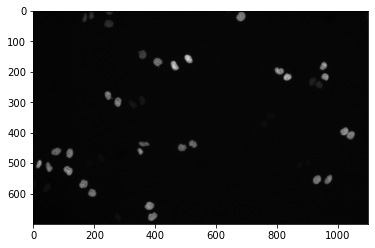

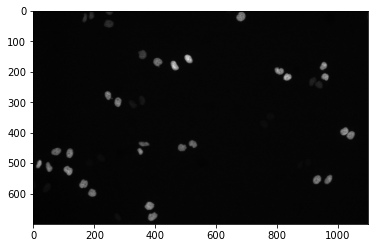

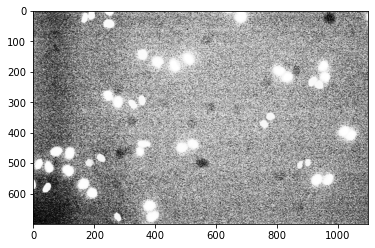

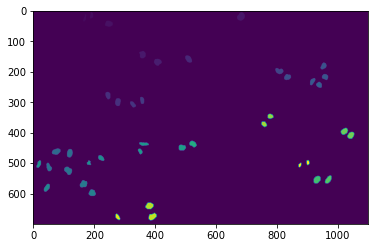

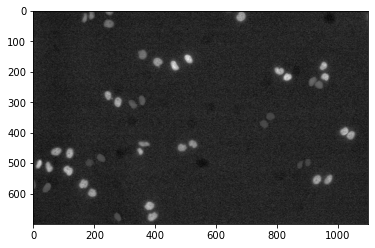

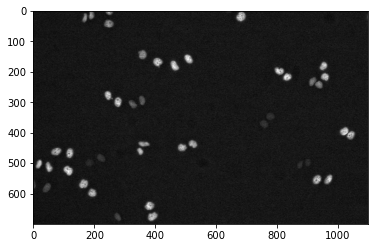

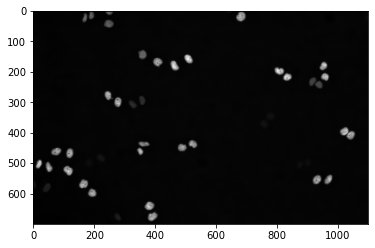

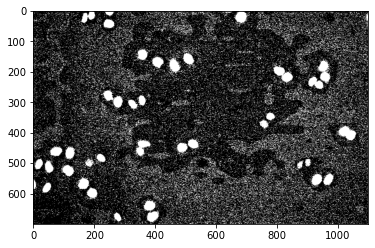

In [35]:
# MAX_PIX_VAL = 255
# MIN_PIX_VAL = 0

# def cont_stretch(img):
#     image = img.copy()
#     max_pixel = np.amax(image)
#     min_pixel = np.amin(image)

#     image = ( (image-min_pixel) * ( (MAX_PIX_VAL-MIN_PIX_VAL) / (max_pixel - min_pixel) ) )
#     image += MIN_PIX_VAL
    
#     return image
    
# #     for r in range(image.shape[0]):
# #         for c in range(image.shape[1]):
# #             image[r,c] = ( (image[r,c]-min_pixel) * ( (MAX_PIX_VAL-MIN_PIX_VAL) / (max_pixel - min_pixel) ) ) + MIN_PIX_VAL

# cell_masks = get_cell_masks(r"Fluo-2\01_ST\SEG")
# origs = get_origs(r"Fluo-2\01")
# cell_markers = get_markers(cell_masks[0], 3)
# weight_maps = get_weight_map(cell_markers, False)

# a = origs[0]
# b = equalize_clahe(origs[0])

# c = cell_masks[0]
# d = cell_markers

# h = weight_maps

# ca = cont_stretch(a).astype('uint8')

# b = cv2.equalizeHist(ca)

# i = (equalize_clahe(ca ,10, (8,8))).astype('uint8')

# j = (equalize_clahe(ca ,5, (34,34))).astype('uint8')
# # j = (cont_stretch(i) > 127).astype('uint8')
# # j =cv2.fastNlMeansDenoising(j, h=1)
# print(len(np.unique(c))-1, len(np.unique(d)-1), np.unique(cont_stretch(a)))

# # k = cv2.adaptiveThreshold(cont_stretch(i).astype('uint8'),255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
# #             cv2.THRESH_BINARY,5,2)

# # k = cv2.fastNlMeansDenoising(j, h=10)

# l = (j > 30).astype('uint8')
# # l = (equalize_clahe(k ,10, (34,34))).astype('uint8')


# pimg(a, grayscale=True)

# pimg(ca, grayscale=True)

# pimg(b, grayscale=True)

# pimg(d, grayscale=False)

# # pimg(h, grayscale=True)

# pimg(i, grayscale=True)

# pimg(j, grayscale=True)

# pimg(k, grayscale=True)
# pimg(l, grayscale=True)

In [11]:
# cell_masks = get_cell_masks()
# origs = get_origs()
# cell_markers = get_cell_markers(cell_masks, 2)
# weight_maps = get_weight_maps(cell_markers, False)

# a = origs[2]
# b = get_clahes(origs)[2]
# c = cell_masks[2]
# d = cell_markers[2]

# h = weight_maps[2]


# pimg(a)

# pimg(b)

# pimg(c)

# pimg(d)

# pimg(h)